# **1. 데이터 차원**
- 데이터 자체는 충분함
- 불균형 데이터 -> Data Augmentation
- 데이터 범위(scale) 조정: 정규화/규제화/표준화

# **2. 알고리즘 차원**
- 학습률(learning rate)
    - Learning rate Scheduler 활용
- 활성화 함수/손실함수
    - 활성화 함수: softmax
    - 손실 함수: CrossEntropyLoss
- 배치/ Epoch
    - batch size: 64
    - Epoch: 100
    - EarlyStopping 적용
      - 사용자 정의 모듈
      - https://github.com/Bjarten/early-stopping-pytorch

# **3. 하드웨어 차원**
- gpu 활용

In [1]:
### 필요한 라이브러리 준비

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import copy
import argparse

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from ipywidgets import interact
from module.pytorchtools import EarlyStopping # 사용자 정의 모듈
                                              # 외부 py파일을 모듈로 import하여 EarlyStopping 함수 사용

In [2]:
### gpu 장치 확인
print(torch.__version__) 
print(torch.cuda.get_device_name(0))

1.12.1+cu116
NVIDIA GeForce GTX 1660 SUPER


### **DataLoader**

In [3]:
train_data_dir = './DataSet/archive/train/'
train_data_df = pd.read_csv(os.path.join(train_data_dir,'train.csv'))

# 분류에 사용할 class 정의(7개의 감정들)
feelings_list = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [4]:
IMAGE_SIZE = 48

### 이미지 파일 경로를 리스트 형태로 저장하기 위한 함수
def list_image_file(data_dir,sub_dir):
    image_files = []
    
    images_dir = os.path.join(data_dir,sub_dir)
    for file_path in os.listdir(images_dir):
        image_files.append(os.path.join(sub_dir,file_path))
    return image_files

In [5]:
### 학습 데이터셋 클래스

class Feeling_dataset(Dataset):
    ### 생성자
    def __init__(self,data_dir,transform = None):
        self.data_dir = data_dir # 데이터가 저장된 상위 directory
        angry_imgs = list_image_file(data_dir,'angry')
        disgust_imgs = list_image_file(data_dir,'disgust')
        fear_imgs = list_image_file(data_dir,'fear')
        happy_imgs = list_image_file(data_dir,'happy')
        neutral_imgs = list_image_file(data_dir,'neutral')
        sad_imgs = list_image_file(data_dir,'sad')
        surprise_imgs = list_image_file(data_dir,'surprise')
        
        # 모든 사진들의 경로를 하나의 리스트에 저장
        self.files_path = angry_imgs + disgust_imgs + fear_imgs + happy_imgs + neutral_imgs + sad_imgs + surprise_imgs
        self.transform = transform
    
    ### 데이터 개수 확인
    def __len__(self):
        return len(self.files_path) # 전체 데이터 개수
    
    ### getitem
    def __getitem__(self,index):
        # image(feature data)
        image_file = os.path.join(self.data_dir,self.files_path[index])
        image = cv2.imread(image_file)
        image = cv2.resize(image,dsize = (IMAGE_SIZE,IMAGE_SIZE),interpolation = cv2.INTER_LINEAR)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        # feeling(target data)
        target = feelings_list.index(self.files_path[index].split(os.sep)[0])
        
        if self.transform:
            image = self.transform(image) # feature data에 대해서만 데이터 변형 수행
            target = torch.Tensor([target]).long()
            
        return {'image':image,'target':target}

In [6]:
### Transformation

# 학습 feature data 변환
train_transformer = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(), # 수평으로 뒤집기
    transforms.RandomVerticalFlip(), # 수직으로 뒤집기
    transforms.ToTensor(), # 텐서로 변환
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # 정규화
])

# 검증 feature data 변환
val_transformer = transforms.Compose([
    transforms.ToTensor(), # 텐서로 변환
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # 정규화
])

In [7]:
### 데이터로더 구현
def build_dataloader(train_data_dir,val_data_dir):
    dataloaders = {}
    train_dset = Feeling_dataset(train_data_dir,train_transformer)
    dataloaders['train'] = DataLoader(train_dset,batch_size = 64,shuffle = True,drop_last = True)
    
    val_dset = Feeling_dataset(val_data_dir,val_transformer)
    dataloaders['val'] = DataLoader(val_dset,batch_size = 64,shuffle = False,drop_last = False)
    
    return dataloaders

In [8]:
train_data_dir = './DataSet/archive/train/'
val_data_dir = train_data_dir = './DataSet/archive/valid/'
dataloaders = build_dataloader(train_data_dir,val_data_dir)

### **Modeling**

In [9]:
from torchsummary import summary

In [10]:
### 모델 생성 함수
# 기존의 ResNet50 모델 호출 -> head 부분 수정
def build_resnet50_based_model():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model = models.resnet50(pretrained = True) # 이미 학습된 resnet50 모델 불러오기
    
    # 일반 NN layer(FC layer)
    model.avgpool = nn.AdaptiveAvgPool2d(output_size = (1,1))
    model.fc = nn.Linear(2048,7) # 7개의 감정으로 분류
    
    return model.to(device)

### **Estimation**

In [11]:
### 모델 검증을 위한 accuracy

@torch.no_grad() 
def get_accuracy(image,target,model):
    batch_size = image.shape[0] 
    prediction = model(image) # 예측 
    _,pred_label = torch.max(prediction,dim = 1) # 예측이 어느 클래스에 속하는지 확률이 가장 높은 1개 선택
    is_correct = (pred_label == target)
    
    return is_correct.cpu().numpy().sum() / batch_size

### **Training**

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Epoch을 1번 수행
def train_one_epoch(dataloaders,model,optimizer,loss_func,device):
    losses = {} # loss값 저장
    accuracies = {} # 정확도 값 저장
    
    for tv in ['train','val']:
        ### loss, accuracy를 계속 갱신
        running_loss = 0.0
        running_correct = 0
        
        if tv == 'train': # 학습
            model.train()
        else: # 검증
            model.eval()
        
        for index,batch in enumerate(dataloaders[tv]):
            image = batch['image'].to(device) # feature data(이미지)
            target = batch['target'].squeeze(dim = 1).to(device) # label data(감정), 1차원으로 차원 축소 진행
            
            ### 역전파 적용
            with torch.set_grad_enabled(tv == 'train'): 
                prediction = model(image) # label 예측
                loss = loss_func(prediction,target) # loss값 계산
                
                if tv == 'train':
                    optimizer.zero_grad() # 한 번의 학습 완료 -> gradient를 0으로 초기화
                    loss.backward() # 역전파
                    optimizer.step() # 가중치 업데이트
                    
            running_loss += loss.item()
            running_correct += get_accuracy(image,target,model)
            
            if tv == 'train':
                if index % 50 == 0:
                    print(f"{index}/{len(dataloaders['train'])} - Running loss: {loss.item()}")
        losses[tv] = running_loss / len(dataloaders[tv])
        accuracies[tv] = running_correct / len(dataloaders[tv])
    return losses, accuracies

In [13]:
### 학습이 잘 된 모델 저장
def save_best_model(model_state,model_name,save_dir = './best_model'):
    os.makedirs(save_dir,exist_ok = True) # 경로 존재 시 덮어쓰기, 없는 경우 새로 생성
    torch.save(model_state,os.path.join(save_dir,model_name)) # 모델 저장

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 경로 설정
train_data_dir = './DataSet/archive/train/'
val_data_dir = './DataSet/archive/valid/'

### 필요한 요소들 준비
dataloaders = build_dataloader(train_data_dir,val_data_dir)
model = build_resnet50_based_model()
loss_func = nn.CrossEntropyLoss(reduction = 'mean')
optimizer = torch.optim.SGD(model.parameters(),lr = 1e-4,momentum = 0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience = 3, factor = 0.1,
                                                       min_lr = 1e-12,verbose = True)  # lr scheduling
early_stopping = EarlyStopping(patience = 20, verbose = False) # 조기 종료(사용자 정의 모듈)

c:\users\bin\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\users\bin\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
num_epochs = 100

best_acc = 0.0
train_loss,train_accuracy = [],[]
val_loss,val_accuracy = [],[]

for epoch in range(num_epochs):
    ### 1 Epoch 수행
    losses, accuracies = train_one_epoch(dataloaders, model, optimizer, loss_func, device)
    
    ### LR Scheduling
    scheduler.step(losses['val']) # 1 Epoch 수행 후 learning rate 조정
    # EarlyStopping
    early_stopping(losses['val'], model) # 현재 과적합 상황 추적
    if early_stopping.early_stop: # 조건 만족 시 조기 종료
        break
        
    train_loss.append(losses['train'])
    val_loss.append(losses['val'])
    train_accuracy.append(accuracies['train'])
    val_accuracy.append(accuracies['val'])
    
    print(f"{epoch+1}/{num_epochs}-Train Loss:{losses['train']}, Val Loss:{losses['val']}")
    print(f"{epoch+1}/{num_epochs}-Train Acc:{accuracies['train']}, Val Acc:{accuracies['val']}")
    
    # deepcopy: 배열의 내부 객체까지 복사를 해서 사용
    # copy: 배열의 내부 객체까지 깊은 복사를 해주지 않음
    if (epoch > 3) and (accuracies['val'] > best_acc):
        best_acc = accuracies['val']
        best_model = copy.deepcopy(model.state_dict()) 
        save_best_model(best_model, f'model_{epoch+1:02d}.pth')

print(f'Best Accuracy: {best_acc}')

0/455 - Running loss: 2.0988454818725586
50/455 - Running loss: 1.8561599254608154
100/455 - Running loss: 1.8189011812210083
150/455 - Running loss: 1.8079971075057983
200/455 - Running loss: 1.9025523662567139
250/455 - Running loss: 1.886741280555725
300/455 - Running loss: 1.8761885166168213
350/455 - Running loss: 1.731248140335083
400/455 - Running loss: 1.7268249988555908
450/455 - Running loss: 1.7072104215621948
1/100-Train Loss:1.812141069475111, Val Loss:1.723397029073615
1/100-Train Acc:0.276717032967033, Val Acc:0.31380556794528697
0/455 - Running loss: 1.629784107208252
50/455 - Running loss: 1.7370715141296387
100/455 - Running loss: 1.6796095371246338
150/455 - Running loss: 1.6167443990707397
200/455 - Running loss: 1.8020786046981812
250/455 - Running loss: 1.614199161529541
300/455 - Running loss: 1.722776174545288
350/455 - Running loss: 1.5990983247756958
400/455 - Running loss: 1.5999606847763062
450/455 - Running loss: 1.620358943939209
2/100-Train Loss:1.6755423

0/455 - Running loss: 1.0729706287384033
50/455 - Running loss: 1.0143938064575195
100/455 - Running loss: 0.8893890976905823
150/455 - Running loss: 0.9180343151092529
200/455 - Running loss: 1.1689988374710083
250/455 - Running loss: 0.9491279721260071
300/455 - Running loss: 1.0522150993347168
350/455 - Running loss: 1.0324325561523438
400/455 - Running loss: 1.284531831741333
450/455 - Running loss: 1.144371509552002
16/100-Train Loss:1.0834458489994427, Val Loss:1.2257541501731204
16/100-Train Acc:0.6027472527472527, Val Acc:0.533094521260779
0/455 - Running loss: 0.9787466526031494
50/455 - Running loss: 1.2598658800125122
100/455 - Running loss: 1.0976287126541138
150/455 - Running loss: 1.1000300645828247
200/455 - Running loss: 0.9860367774963379
250/455 - Running loss: 0.8759072422981262
300/455 - Running loss: 1.03736412525177
350/455 - Running loss: 1.0893175601959229
400/455 - Running loss: 1.1346430778503418
450/455 - Running loss: 0.9843305349349976
17/100-Train Loss:1.0

50/455 - Running loss: 0.7704535126686096
100/455 - Running loss: 0.9337287545204163
150/455 - Running loss: 0.9094880223274231
200/455 - Running loss: 0.8619600534439087
250/455 - Running loss: 0.8670527338981628
300/455 - Running loss: 0.633328914642334
350/455 - Running loss: 1.079775094985962
400/455 - Running loss: 0.7995097637176514
450/455 - Running loss: 0.8120762705802917
Epoch 00030: reducing learning rate of group 0 to 1.0000e-07.
EarlyStopping counter: 12 out of 20
30/100-Train Loss:0.8796639713612232, Val Loss:1.2183725724094792
30/100-Train Acc:0.6752747252747253, Val Acc:0.5481712756467441
0/455 - Running loss: 0.8388398289680481
50/455 - Running loss: 0.703551173210144
100/455 - Running loss: 0.7612560391426086
150/455 - Running loss: 0.8745872974395752
200/455 - Running loss: 0.7268880605697632
250/455 - Running loss: 0.9819804430007935
300/455 - Running loss: 0.7276630401611328
350/455 - Running loss: 0.8425476551055908
400/455 - Running loss: 0.8314740657806396
450/4

50/455 - Running loss: 0.8231632113456726
100/455 - Running loss: 0.9504548907279968
150/455 - Running loss: 0.8502150774002075
200/455 - Running loss: 0.9368226528167725
250/455 - Running loss: 0.8190157413482666
300/455 - Running loss: 0.8672385811805725
350/455 - Running loss: 0.6590487360954285
400/455 - Running loss: 0.890068531036377
450/455 - Running loss: 0.8745505809783936
EarlyStopping counter: 9 out of 20
44/100-Train Loss:0.8747125877128853, Val Loss:1.2211036954009742
44/100-Train Acc:0.6787431318681318, Val Acc:0.5512330880166518
0/455 - Running loss: 0.8731582760810852
50/455 - Running loss: 0.8975299596786499
100/455 - Running loss: 0.8383335471153259
150/455 - Running loss: 0.8180410265922546
200/455 - Running loss: 0.8529981374740601
250/455 - Running loss: 1.011522650718689
300/455 - Running loss: 0.8425691723823547
350/455 - Running loss: 0.8407591581344604
400/455 - Running loss: 0.990990161895752
450/455 - Running loss: 1.0986474752426147
EarlyStopping counter: 10

50/455 - Running loss: 1.0505324602127075
100/455 - Running loss: 0.728019654750824
150/455 - Running loss: 0.7571393847465515
200/455 - Running loss: 0.99488765001297
250/455 - Running loss: 0.6973785161972046
300/455 - Running loss: 0.8161994814872742
350/455 - Running loss: 0.5919175148010254
400/455 - Running loss: 0.8142300248146057
450/455 - Running loss: 0.8128569722175598
EarlyStopping counter: 7 out of 20
58/100-Train Loss:0.8714880116693267, Val Loss:1.214869473064155
58/100-Train Acc:0.6792239010989011, Val Acc:0.5487659827534939
0/455 - Running loss: 0.8309234380722046
50/455 - Running loss: 0.8757428526878357
100/455 - Running loss: 0.6248677968978882
150/455 - Running loss: 0.9496628046035767
200/455 - Running loss: 1.0507125854492188
250/455 - Running loss: 1.0003712177276611
300/455 - Running loss: 1.0717380046844482
350/455 - Running loss: 0.7917857766151428
400/455 - Running loss: 0.9055071473121643
450/455 - Running loss: 0.8665396571159363
EarlyStopping counter: 8 o

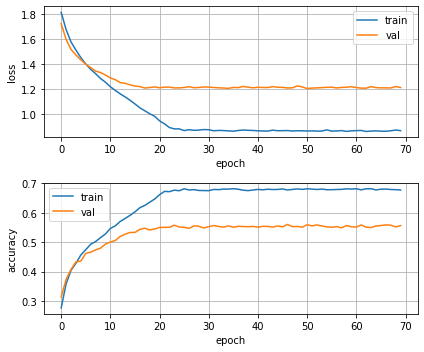

In [16]:
### Loss, Accuracy 시각화

plt.figure(figsize = (6,5))

# Loss
plt.subplot(211)
plt.plot(train_loss,label = "train")
plt.plot(val_loss,label = "val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid("on")
plt.legend()

# Accuracy
plt.subplot(212)
plt.plot(train_accuracy,label = "train")
plt.plot(val_accuracy,label = "val")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid("on")
plt.legend()

plt.tight_layout()